# IMPORTING LIBRARIES AND READING THE DATASET

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

df_nasdaq = pd.read_csv("NDAQ.csv")


# PRE-PROCESSING DATASET

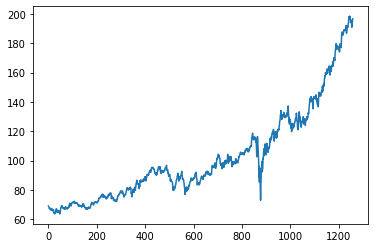

In [ ]:
# Extracting the closing prices from DataFrame
df = df_nasdaq.reset_index()['Close']

# Plotting the values
plt.plot(df)

In [ ]:
# Scaling the data between 0-1 
# Because LSTM model works better with scaled data

scaler = MinMaxScaler(feature_range = (0, 1))

df = scaler.fit_transform(np.array(df).reshape(-1, 1))

In [ ]:
# SPLITTING THR DATA INTO TRAINING AND TESTING SET

split_size = 0.8
training_size = int(len(df)*split_size)

train_data =  df[0:training_size, :]
test_data = df[training_size:, :1]

In [ ]:
# PRE-PROCESSING TRAINING AND TESTING DATA INTO X (FEATURES) AND Y (VALUES)

timestep = 25

def preprocess_data(dataset, timestep):
  X_train, Y_train = [], []
  for i in range(len(dataset) - timestep-1):
    X_temp = dataset[i:(i+timestep), 0]
    Y_temp = dataset[i+timestep, 0]
    
    X_train.append(X_temp)
    Y_train.append(Y_temp)

  return np.array(X_train), np.array(Y_train)

x_train, y_train = preprocess_data(train_data, timestep)
x_test, y_test = preprocess_data(test_data, timestep)

In [ ]:
# Converting 2D Array into 3D Array (FOR fitting in LSTM Model)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1 )
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1 )

# CREATING A STACKED LSTM MODEL

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=x_train.shape[-2:]),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(32, activation='relu', return_sequences=False),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()


# CREATING A LEARNING RATE SCHEDULER :
def scheduler(epoch, lr):
    rate = 1 - 0.02
    if epoch%2 == 0:
        return lr*rate
    return lr

LRscheduler = LearningRateScheduler(scheduler)
callbacks = [LRscheduler]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 25, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 25, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 64)            49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
__________________________________________________

In [ ]:
# Fitting the model on Training Dataset

history = lstm_model.fit(x_train, y_train, epochs = 50, validation_data=(x_test, y_test), verbose = 2, callbacks = callbacks) 

Epoch 1/50
31/31 - 6s - loss: 0.0141 - val_loss: 0.0505
Epoch 2/50
31/31 - 2s - loss: 0.0013 - val_loss: 0.0060
Epoch 3/50
31/31 - 2s - loss: 0.0010 - val_loss: 0.0055
Epoch 4/50
31/31 - 2s - loss: 9.6615e-04 - val_loss: 0.0043
Epoch 5/50
31/31 - 2s - loss: 9.7562e-04 - val_loss: 0.0056
Epoch 6/50
31/31 - 2s - loss: 8.7398e-04 - val_loss: 0.0017
Epoch 7/50
31/31 - 2s - loss: 8.3948e-04 - val_loss: 0.0020
Epoch 8/50
31/31 - 2s - loss: 7.9806e-04 - val_loss: 0.0014
Epoch 9/50
31/31 - 2s - loss: 7.6924e-04 - val_loss: 0.0012
Epoch 10/50
31/31 - 2s - loss: 7.9487e-04 - val_loss: 0.0023
Epoch 11/50
31/31 - 2s - loss: 7.8287e-04 - val_loss: 9.8069e-04
Epoch 12/50
31/31 - 2s - loss: 7.1353e-04 - val_loss: 9.3197e-04
Epoch 13/50
31/31 - 2s - loss: 7.0356e-04 - val_loss: 7.8205e-04
Epoch 14/50
31/31 - 2s - loss: 6.7412e-04 - val_loss: 0.0015
Epoch 15/50
31/31 - 2s - loss: 7.0916e-04 - val_loss: 7.0059e-04
Epoch 16/50
31/31 - 2s - loss: 5.8889e-04 - val_loss: 8.5027e-04
Epoch 17/50
31/31 - 2s - 

# EVALUATING THE MODEL

In [ ]:
test_predict = lstm_model.predict(x_test)
train_predict = lstm_model.predict(x_train)

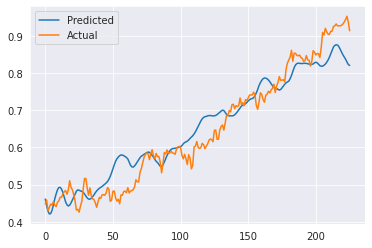

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
plt.plot(test_predict, label = "Predicted")
plt.plot(test_data[0:len(test_predict)], label = "Actual")
plt.legend()

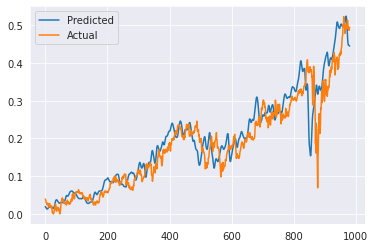

In [ ]:
plt.plot(train_predict, label = "Predicted")
plt.plot(train_data[0:len(train_predict)], label = "Actual")
plt.legend()

# PREDICTING FUTURE PRICES

In [ ]:
x_input = test_data[len(test_data)-timestep: ].reshape(1,-1)

temp_input = list(x_input)

temp_input = temp_input[0].tolist()

lst_output = []

for i in range(30):

  if(len(temp_input)>timestep):
    print(type(temp_input[0]))
    x_input = np.array(temp_input[1:])
    x_input = x_input.reshape(-1, 1)
    x_input = x_input.reshape((1, timestep, 1))
    #
    y_pred = lstm_model.predict(x_input, verbose = 0)
    temp_input.append(y_pred[0][0].tolist())
    temp_input = temp_input[1:]
    lst_output.append(y_pred[0].tolist())
  
  else:
    x_input = x_input.reshape((1, timestep, 1))
    y_pred = lstm_model.predict(x_input, verbose = 0)
    temp_input.append(y_pred[0][0].tolist())
    lst_output.extend(y_pred[0].tolist())




new_lst = []

for i in range(len(lst_output)):
  if i == 0:
    new_lst.append(lst_output[i])
  else:
    new_lst.append(lst_output[i][0])



<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [ ]:
future = np.arange(100, 131)
prev = np.arange(0, 100)

new_lst = np.array(new_lst).reshape(-1, 1)

prev = np.array(prev).reshape(-1, 1)
future = np.array(future[1:]).reshape(-1, 1)

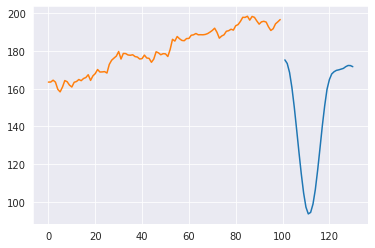

In [ ]:
plt.plot(future, scaler.inverse_transform(new_lst))
plt.plot(prev, scaler.inverse_transform(df[1159: ]))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0, 0.5, 'Days')

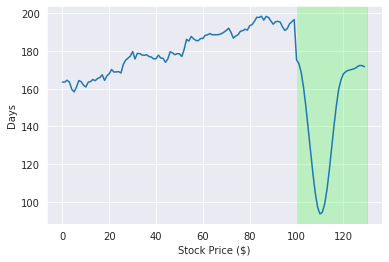

In [ ]:
df_nasdaq = df_nasdaq.reset_index()['Close']
df_predict=df_nasdaq.tolist()
df_predict.extend(scaler.inverse_transform(new_lst))

import seaborn as sns
sns.set_style("darkgrid")
plt.plot(df_predict[1159:])
plt.axvspan(100, 130, color='lime', alpha=0.2)
plt.xlabel("Stock Price ($)")
plt.ylabel("Days")
